In [6]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
os.getcwd()
os.chdir("/home/mbilkis/Desktop/qmon-sindy")
from numerics.utilities.misc import *
import matplotlib.pyplot as plt 



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:

params, exp_path = give_params()

gamma, omega, n, eta, kappa, b, [periods, ppp] = params
period = (2*np.pi/omega)
total_time = period*periods
dt = period/ppp
times = np.arange(0,total_time+dt,dt)


In [9]:
params

[0.3, 10.0, 10.0, 1.0, 20.0, [0.0, 0.1], [10.0, 500]]

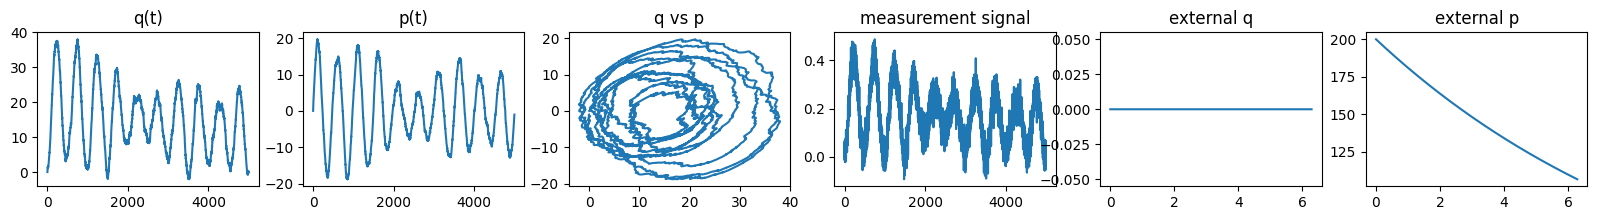

In [10]:
x = load_data(itraj=1, what="hidden_state.npy")
dy = load_data(itraj=1,what="dys.npy")
f = load_data(itraj=1, what="external_signal.npy")

params, exp_path = give_params()

####
gamma, omega, n, eta, kappa, b, [periods, ppp] = params
period = (2*np.pi/omega)
total_time = period*periods
dt = period/ppp

times = np.arange(0,total_time+dt,dt)
if len(times)> int(1e8):
    times = np.linspace(times[0],times[-1],int(1e4))
    
plt.figure(figsize=(20,2))
ax=plt.subplot(161)
ax.plot(x[:,0])
ax.set_title("q(t)")
ax=plt.subplot(162)
ax.plot(x[:,1])
ax.set_title("p(t)")

ax=plt.subplot(163)
ax.plot(x[:,0],x[:,1])
ax.set_title("q vs p")
ax=plt.subplot(164)
ax.plot(dy[:,0])
ax.set_title("measurement signal")
ax=plt.subplot(165)
ax.plot(times,f[:,0])
ax.set_title("external q")

ax=plt.subplot(166)
ax.set_title("external p")
ax.plot(times,f[:,1])

In [11]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import solve_continuous_are


Question 2 talk w/ giulio; f should be (0,f) right ? to be a force... so we put some dynamics in one component only? Maybe it's easier but also more boring ...?

In [12]:
class GRNN(torch.nn.Module):
    def __init__(self,inputs_cell):
        super(GRNN, self).__init__()
        
        self.dt, self.simulation_params, initial_force_params = inputs_cell
        gamma, omega, n, eta, kappa, b = self.simulation_params 
        
        self.damping_force = torch.nn.Parameter(data = torch.tensor(initial_force_params[0],dtype=torch.float32,
                                                              requires_grad=True))
        
        #self.amplitude_force = torch.nn.Parameter(data = torch.tensor(initial_force_params[1],dtype=torch.float32,
        #                                              requires_grad=False))
        
        self.amplitude_force = torch.tensor(initial_force_params[1],dtype=torch.float32)
        
        self.A = torch.tensor(data=[[-gamma/2, omega],[-omega,-gamma/2]], dtype=torch.float32).detach()
        self.proj_C = torch.tensor(data=[[1.,0.],[0.,0.]], dtype=torch.float32).detach()
        self.C = np.sqrt(4*eta*kappa)*self.proj_C.detach()
        self.D = (gamma*(n+0.5) + kappa)*torch.eye(2).detach()

        
        
    def forward(self, dy, state):
        """
        input_data is dy
        hidden_state is x: (<q>, <p>, Var[x], Var[p], Cov(q,q)})
        output dy_hat
        """
        x = state[:2]
        [vx,vp,cxp] = state[2:5]
        f = state[5:-1]
        t = state[-1]
        cov = torch.tensor(data = [[vx,cxp],[cxp,vp]], dtype=torch.float32)
        
        xicov = cov.matmul(self.C.T)
        
        dx = (self.A - xicov.matmul(self.C)).matmul(x)*dt + xicov.matmul(dy)
        
        ### signal part 
        #### g0(f) = f, g1(f) = f**3<
        #dictionary = torch.concatenate([f, f**2, f**3, f**4])
       # 
        #df = self.coeffs_f.dot(dictionary) ###Check this!
        #fnew = f+ df
        fnew = torch.exp(-self.damping_force*(t+dt))*self.amplitude_force
        
        dx += fnew*dt
        
        dcov = self.dt*(cov.matmul(self.A.T) + (self.A).matmul(cov) + self.D - (xicov.matmul(xicov.T)))
        ncov = cov+dcov
        

        nstate = torch.concatenate([(x + dx), torch.tensor([ncov[0,0],ncov[1,1],ncov[1,0]]), fnew, torch.tensor([t+self.dt])])

        dy_hat = self.C.matmul(x)*self.dt

        return nstate, dy_hat

class RecurrentNetwork(torch.nn.Module):
    def __init__(self,inputs_cell):
        super(RecurrentNetwork, self).__init__()
        self.RCell = GRNN(inputs_cell=inputs_cell)
        self.params = inputs_cell[1]
        self.initial_amplitude = inputs_cell[2][1]
        
    def forward(self, dys):
        dys_hat = []
        
        ### Find stationary value of covariance for the parameter RCell currently has
        gamma, omega, n, eta, kappa, b = self.params 
        A = np.array([[-gamma/2, omega],[-omega, -gamma/2]])
        proj_C = np.array([[1.,0.],[0.,0.]])
        C = np.sqrt(4*eta*kappa)*proj_C
        D = np.diag([gamma*(n+0.5) + kappa]*2)
        G = np.zeros((2,2))
        Cov = solve_continuous_are((A-G.dot(C)).T, C.T, D- (G.T).dot(G), np.eye(2)) #### A.T because the way it's implemented!
        t0=0.
        f0x,f0y = self.initial_amplitude 
        xs_hat = [torch.tensor([0., 0., Cov[0,0], Cov[1,1],Cov[1,0], f0x, f0y, t0], dtype=torch.float32)]
        x_hat = xs_hat[0]
        for dy_t in dys:
            x_hat, dy_hat = self.RCell(dy_t, x_hat)
            dys_hat += [dy_hat]
            xs_hat += [x_hat]
        return torch.stack(xs_hat), torch.stack(dys_hat)

In [13]:
x = load_data(itraj=1, what="hidden_state.npy")
dy = load_data(itraj=1,what="dys.npy")
f = load_data(itraj=1, what="external_signal.npy")

params, exp_path = give_params()

####
gamma, omega, n, eta, kappa, b, [periods, ppp] = params
period = (2*np.pi/omega)
total_time = period*periods
dt = period/ppp

times = np.arange(0,total_time+dt,dt)

In [22]:
inputs_cell = [dt,  [gamma, omega, n, eta, kappa, b], [10.,[0., 200.]]]

x = load_data(itraj=1, what="hidden_state.npy")
dy = load_data(itraj=1,what="dys.npy")

dev = torch.device("cpu")
rrn = RecurrentNetwork(inputs_cell)
dys = torch.tensor(data=dy, dtype=torch.float32).to(dev)
xs_hat, dys_hat = rrn(dys)

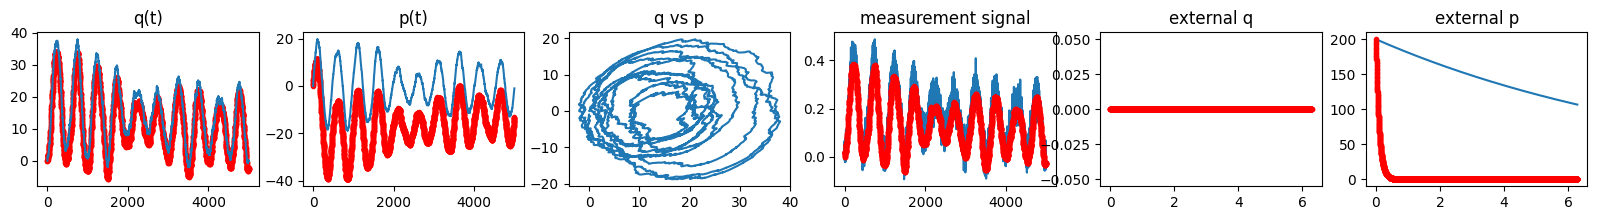

In [23]:
plt.figure(figsize=(20,2))
ax=plt.subplot(161)
ax.plot(xs_hat.detach().numpy()[:,0], color="red",marker='.')
ax.plot(x[:,0])

ax.set_title("q(t)")
ax=plt.subplot(162)
ax.plot(xs_hat.detach().numpy()[:,1], color="red",marker='.')
ax.plot(x[:,1])

ax.set_title("p(t)")

ax=plt.subplot(163)
ax.plot(x[:,0],x[:,1])
ax.set_title("q vs p")
ax=plt.subplot(164)
ax.plot(dy[:,0])
ax.plot(dys_hat.detach().numpy()[:,0], color="red",marker='.')

ax.set_title("measurement signal")
ax=plt.subplot(165)
ax.plot(times,f[:,0])
ax.plot(times,xs_hat.detach().numpy()[:-1,5], color="red",marker='.')

ax.set_title("external q")

ax=plt.subplot(166)
ax.set_title("external p")
ax.plot(times,f[:,1])
ax.plot(times,xs_hat.detach().numpy()[:-1,6], color="red",marker='.')





# Training

In [16]:
def log_lik(dys, dys_hat):
    return torch.sum((dys-dys_hat)**2)/(dt*len(dys))

In [17]:
def err_f(f,xs_hat):
    return np.sum(np.abs(f - xs_hat[:-1,5:7].detach().numpy() ))/np.sum(np.abs(f))

In [24]:
torch.manual_seed(0)
inputs_cell = [dt,  [gamma, omega, n, eta, kappa, b], [1.,[0., 200.]]]

x = load_data(itraj=1, what="hidden_state.npy")
dy = load_data(itraj=1,what="dys.npy")

dev = torch.device("cpu")
rrn = RecurrentNetwork(inputs_cell)


optimizer = torch.optim.Adam(list(rrn.parameters()), lr=1e-1)

dys = torch.tensor(data=dy, dtype=torch.float32).to(torch.device("cpu"))

history = {}
history["losses"] = []
history["params"] = [k.detach().numpy() for k in list(rrn.parameters())]
history["gradients"] = []

xs_hat, dys_hat = rrn(dys)
loss = log_lik(dys, dys_hat)
print(loss.item())
print(err_f(f,xs_hat))
print("\n")
history["losses"].append([loss.item(),err_f(f,xs_hat)] )

for ind in tqdm(range(40)):
    xs_hat, dys_hat = rrn(dys)
    loss = log_lik(dys, dys_hat)
    loss.backward()
    
    optimizer.step()
    history["losses"].append([loss.item(),err_f(f,xs_hat)] )
    history["params"].append([k.detach().numpy() for k in list(rrn.parameters())])
    history["gradients"].append([k.grad.numpy() for k in list(rrn.parameters())])
    
    print(loss.item())
    print(err_f(f,xs_hat))
    print("\n")
    optimizer.zero_grad()

1.7591962814331055
0.7859482680441823




  2%|███▎                                                                                                                                  | 1/40 [00:03<02:00,  3.08s/it]

1.7591962814331055
0.7859482680441823




  5%|██████▋                                                                                                                               | 2/40 [00:06<02:00,  3.17s/it]

1.7179187536239624
0.7625683923519287




  8%|██████████                                                                                                                            | 3/40 [00:09<01:54,  3.10s/it]

1.6685123443603516
0.7337009401024768




 10%|█████████████▍                                                                                                                        | 4/40 [00:12<01:49,  3.05s/it]

1.6087111234664917
0.6973566248635382




 12%|████████████████▊                                                                                                                     | 5/40 [00:15<01:49,  3.12s/it]

1.535672664642334
0.6506120611147649




 15%|████████████████████                                                                                                                  | 6/40 [00:18<01:47,  3.15s/it]

1.4461569786071777
0.5890827341046811




 18%|███████████████████████▍                                                                                                              | 7/40 [00:21<01:43,  3.14s/it]

1.3374428749084473
0.5060335293028997




 20%|██████████████████████████▊                                                                                                           | 8/40 [00:25<01:41,  3.16s/it]

1.2105190753936768
0.39079131556298424




 22%|██████████████████████████████▏                                                                                                       | 9/40 [00:28<01:38,  3.17s/it]

1.0803616046905518
0.22575296372363632




 25%|█████████████████████████████████▎                                                                                                   | 10/40 [00:31<01:33,  3.12s/it]

1.0093780755996704
0.017937637354678338




 28%|████████████████████████████████████▌                                                                                                | 11/40 [00:34<01:29,  3.10s/it]

1.1529042720794678
0.33189534262599096




 30%|███████████████████████████████████████▉                                                                                             | 12/40 [00:37<01:26,  3.07s/it]

1.1822352409362793
0.36274245603712707




 32%|███████████████████████████████████████████▏                                                                                         | 13/40 [00:40<01:23,  3.08s/it]

1.0882004499435425
0.2494690372200286




 35%|██████████████████████████████████████████████▌                                                                                      | 14/40 [00:43<01:20,  3.10s/it]

1.021313190460205
0.10378765096824664




 38%|█████████████████████████████████████████████████▉                                                                                   | 15/40 [00:46<01:17,  3.10s/it]

1.010704517364502
0.02372423849993124




 40%|█████████████████████████████████████████████████████▏                                                                               | 16/40 [00:49<01:15,  3.15s/it]

1.0303735733032227
0.11789802511787788




 42%|████████████████████████████████████████████████████████▌                                                                            | 17/40 [00:53<01:14,  3.26s/it]

1.0558239221572876
0.1803462226432826




 45%|███████████████████████████████████████████████████████████▊                                                                         | 18/40 [00:56<01:12,  3.29s/it]

1.0751444101333618
0.21682937050915815




 48%|███████████████████████████████████████████████████████████████▏                                                                     | 19/40 [01:00<01:09,  3.29s/it]

1.0843480825424194
0.23236017773986084




 50%|██████████████████████████████████████████████████████████████████▌                                                                  | 20/40 [01:03<01:07,  3.36s/it]

1.08304762840271
0.23022380257222397




 52%|█████████████████████████████████████████████████████████████████████▊                                                               | 21/40 [01:06<01:03,  3.33s/it]

1.072510004043579
0.21219391790689365




 55%|█████████████████████████████████████████████████████████████████████████▏                                                           | 22/40 [01:10<00:59,  3.33s/it]

1.0551800727844238
0.17901427999899885




 57%|████████████████████████████████████████████████████████████████████████████▍                                                        | 23/40 [01:13<00:54,  3.23s/it]

1.0349189043045044
0.13103691009438365




 60%|███████████████████████████████████████████████████████████████████████████████▊                                                     | 24/40 [01:16<00:51,  3.21s/it]

1.0173602104187012
0.06925061198238806




 62%|███████████████████████████████████████████████████████████████████████████████████▏                                                 | 25/40 [01:19<00:47,  3.20s/it]

1.0093270540237427
0.002888333664229422




 65%|██████████████████████████████████████████████████████████████████████████████████████▍                                              | 26/40 [01:22<00:44,  3.15s/it]

1.0153871774673462
0.07669154944700009




 68%|█████████████████████████████████████████████████████████████████████████████████████████▊                                           | 27/40 [01:25<00:40,  3.08s/it]

1.0311387777328491
0.1364477182449845




 70%|█████████████████████████████████████████████████████████████████████████████████████████████                                        | 28/40 [01:28<00:36,  3.08s/it]

1.0418468713760376
0.16427546038115995




 72%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 29/40 [01:31<00:34,  3.16s/it]

1.0371171236038208
0.152666463167639




 75%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 30/40 [01:35<00:32,  3.22s/it]

1.0230331420898438
0.11028421716023006




 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████                              | 31/40 [01:38<00:28,  3.13s/it]

1.011954426765442
0.053927586407456304




 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 32/40 [01:41<00:24,  3.12s/it]

1.0094249248504639
0.0014802060600520306




 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 33/40 [01:44<00:21,  3.06s/it]

1.013420581817627
0.04690988959526505




 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 34/40 [01:47<00:18,  3.00s/it]

1.0193662643432617
0.07849008051599918




 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 35/40 [01:50<00:14,  2.98s/it]

1.023599624633789
0.09538074366389115




 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 36/40 [01:53<00:12,  3.04s/it]

1.0243552923202515
0.09812180056847647




 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 37/40 [01:56<00:09,  3.02s/it]

1.0216171741485596
0.08783079294058865




 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 38/40 [01:59<00:05,  2.99s/it]

1.0167207717895508
0.06607139529336395




 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 39/40 [02:01<00:02,  2.96s/it]

1.0118712186813354
0.035181343458267345




100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [02:05<00:00,  3.13s/it]

1.0093605518341064
0.0011323821956747695




In [19]:
ll = np.stack(history["losses"])

Text(0, 0.5, '$\\frac{\\sum_k |f_k - \\hat{f}_k|}{\\sum_k |f_k|}$')

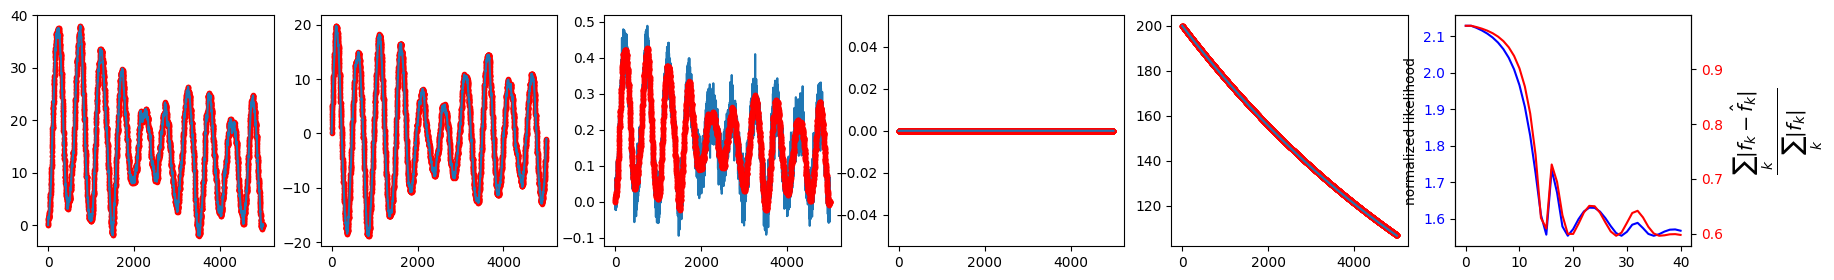

In [27]:
plt.figure(figsize=(25,3))
ax=plt.subplot(171)
ax.plot(xs_hat.detach().numpy()[:,0], color="red",marker='.')
ax.plot(x[:,0])
ax=plt.subplot(172)
ax.plot(xs_hat.detach().numpy()[:,1], color="red",marker='.')
ax.plot(x[:,1])
ax=plt.subplot(173)
ax.plot(dys[:,0])
ax.plot(dys_hat.detach().numpy()[:,0], color="red",marker='.')

ax=plt.subplot(174)
ax.plot(xs_hat.detach().numpy()[:,5], color="red",marker='.')
ax.plot(f[:,0])
ax=plt.subplot(175)
ax.plot(xs_hat.detach().numpy()[:,6], color="red",marker='.')
ax.plot(f[:,1])

ax=plt.subplot(176)
ax.plot(ll[:,0], color="blue")
ax.set_ylabel("normalized likelihood")
ax.tick_params(axis='y', labelcolor="blue")
ax = ax.twinx()
ax.plot(ll[:,1], color="red")
ax.tick_params(axis='y', labelcolor="red")
ax.set_ylabel(r'$\frac{\sum_k |f_k - \hat{f}_k|}{\sum_k |f_k|}$',size=20)

In [26]:
import pickle
itraj = 1
path = get_def_path()+ exp_path + "{}itraj/T_{}_dt_{}/".format(itraj, total_time, dt)+"/EXPONENTIALLY_DEC/PROFILE_only_gamma/"
os.makedirs(path,exist_ok=True)

with open(path+"history.pickle", "wb") as output_file:
   pickle.dump(history, output_file)